# Load the dataset

In [1]:
import random
import numpy as np
import torch
import pytorch_lightning as pl

SEED = 172

# Set seed for Python's random module
random.seed(SEED)

# Set seed for NumPy
np.random.seed(SEED)

# Set seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.

# Set seed for PyTorch Lightning
pl.seed_everything(SEED)

Seed set to 172


172

In [ ]:
# Code to mount google drive in Google Colab.

# from google.colab import drive
# import pandas as pd
# import os
# drive.mount('/content/gdrive', force_remount=True)


# You theoretically can access the dataset through the network stored in Google Drive, like so:
# dataset_folder = "/content/gdrive/MyDrive/MC959 - Datasets/Airbus Wind Turbines Patches"

# However, using this approach would probably be slow. Use the approach in the cell below instead.

In [ ]:
# If on Google Colab, use the following code to unzip the dataset

# Upload the kaggle dataset archive to 'kaggle-dataset-archive.zip'
# in the Files panel

# The unzip process takes around 4 minutes
# !apt-get install unzip
# !unzip '/content/gdrive/MyDrive/MC959 - Datasets/Airbus Wind Turbines Patches/kaggle-dataset-archive.zip' -d './Airbus Wind Turbines Patches/'
# # !unzip kaggle-dataset-archive.zip -d './Airbus Wind Turbines Patches/'
# dataset_folder = './Airbus Wind Turbines Patches/'

In [2]:
# When in local development, just download and extract the dataset into a folder
# and set the dataset_folder variable to the path of that folder
dataset_folder = 'C:\\Users\\diego\\Documents\\TEMP_MC959\\Airbus Wind Turbines Patches'

In [3]:
import os

base_train_background_filenames = [os.path.join(dataset_folder, 'train', 'background', file) for file in os.listdir(f'{dataset_folder}/train/background')]
base_train_target_filenames = [os.path.join(dataset_folder, 'train', 'target', file) for file in os.listdir(f'{dataset_folder}/train/target')]
base_val_background_filenames = [os.path.join(dataset_folder, 'val', 'background', file) for file in os.listdir(f'{dataset_folder}/val/background')]
base_val_target_filenames = [os.path.join(dataset_folder, 'val', 'target', file) for file in os.listdir(f'{dataset_folder}/val/target')]

In [4]:
all_background_filenames = base_train_background_filenames + base_val_background_filenames
all_target_filenames = base_train_target_filenames + base_val_target_filenames

from sklearn.model_selection import train_test_split

# Split the entire dataset into a dataset used for fine-tuning and the rest (used for later stages)
fine_tuning_background_filenames, rest_background_filenames = train_test_split(all_background_filenames, test_size=0.25, random_state=SEED)
fine_tuning_target_filenames, rest_target_filenames = train_test_split(all_target_filenames, test_size=0.25, random_state=SEED)

# Split the rest dataset into 70% train, 15% test, 15% validation
train_background_filenames, rest_background_filenames = train_test_split(rest_background_filenames, test_size=0.3, random_state=SEED)
valid_background_filenames, test_background_filenames = train_test_split(rest_background_filenames, test_size=0.5, random_state=SEED)

train_target_filenames, rest_target_filenames = train_test_split(rest_target_filenames, test_size=0.3, random_state=SEED)
valid_target_filenames, test_target_filenames = train_test_split(rest_target_filenames, test_size=0.5, random_state=SEED)

In [10]:
len(all_background_filenames), len(all_target_filenames), len(all_background_filenames) + len(all_target_filenames)

(243078, 180179, 423257)

In [5]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.v2 as transforms

# Reads the image from the filesystem when needed, to avoid overflowing RAM
class AirbusDataset(Dataset):
  def __init__(self, background_filenames, target_filenames, transform=None, target_transform=None):
    all_filenames_with_label = [(f,0) for f in background_filenames] + \
                               [(f,1) for f in target_filenames]
    self.filenames = [file_name_label[0] for file_name_label in all_filenames_with_label]
    self.labels = [file_name_label[1] for file_name_label in all_filenames_with_label]

    self.images = self.filenames
    # self.images = [Image.open(filename) for filename in filenames]
    # self.images = [np.asarray(pil_image) for pil_image in self.images]

    self.transform = transform
    self.target_transform = target_transform

    #   self.images = [transform(image) for image in self.images]

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self, idx):
    '''
    Return a tuple with the image and the respective target at position idx.
    '''
    image = Image.open(self.images[idx])
    label = self.labels[idx]

    if self.transform != None:
      image = self.transform(image)
      
    if self.target_transform != None:
      label = self.target_transform(label)

    return image, label

preprocess_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = AirbusDataset(
    train_background_filenames,
    train_target_filenames,
    transform=preprocess_transform
  )

valid_dataset = AirbusDataset(
    valid_background_filenames,
    valid_target_filenames,
    transform=preprocess_transform
  )

test_dataset = AirbusDataset(
    test_background_filenames,
    test_target_filenames,
    transform=preprocess_transform
  )

fine_tuning_dataset = AirbusDataset(
    fine_tuning_background_filenames,
    fine_tuning_target_filenames,
    transform=preprocess_transform
  )

d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(valid_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Fine-tuning dataset size: {len(fine_tuning_dataset)}')

Train dataset size: 74070
Validation dataset size: 15872
Test dataset size: 15873
Fine-tuning dataset size: 317442


We can see that our dataset has a good amount of data points for us to work with. Even in the training dataset (70% of the 25% section of our dataset not reserved for fine tuning) has a good amount of data. This might result in the full supervised method yielding good results.

Number of images: 74070
Images are 224x224x3
Class of the image:  0


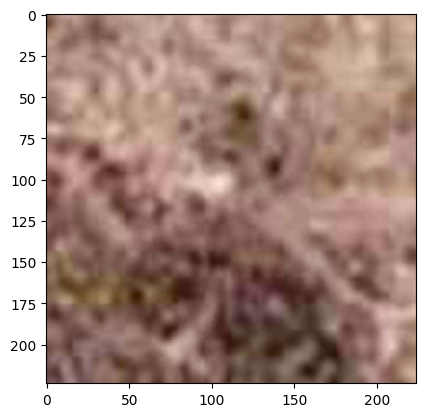

Class of the image:  0


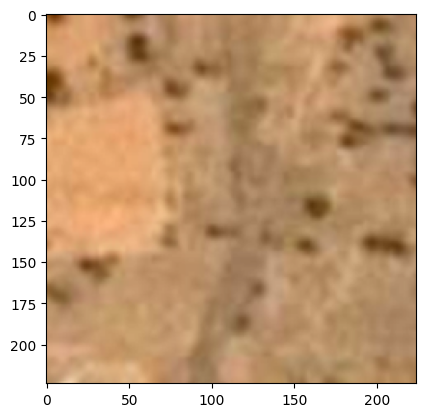

Class of the image:  0


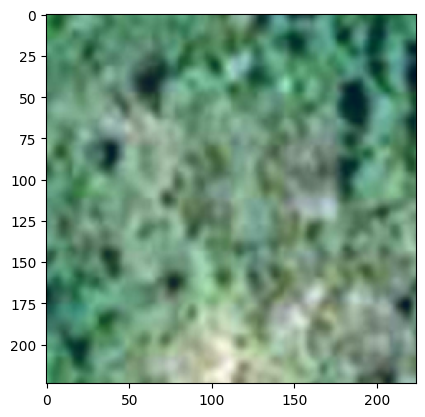

In [8]:
import matplotlib.pyplot as plt
# Visualize images from the training set

def show_image(idx):
  image, target = train_dataset[idx] # This will execute the '__getitem__' method
  nchannels = image.shape[0]
  height    = image.shape[1]
  width     = image.shape[2]
  image     = image.permute(1,2,0).numpy() # Converts the Tensor back to image shape
  image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
  image     = image.astype('uint8')
  plt.imshow(image)
  print("Class of the image: ", target)
  plt.show()

print("Number of images:", len(train_dataset))
sample_image, target = train_dataset[100] # This will execute the '__getitem__' method
nchannels = sample_image.shape[0]
height    = sample_image.shape[1]
width     = sample_image.shape[2]
print("Images are {}x{}x{}".format(width,height,nchannels))

show_image(10)
show_image(50)
show_image(100)

# Dependencies

In [ ]:
!pip install tensorboard seaborn matplotlib lightly sklearn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Fully Supervised Training

## Using GPU

In [11]:
import torch
import torchvision
from torch import nn
import pytorch_lightning as pl

In [12]:
if not torch.cuda.is_available():
  print("GPU not available!")

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [13]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Model (Generic CNN with Fully Connected Layers)

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

class SupervisedCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Instantiate the ResNet backbone
        # resnet = torchvision.models.resnet18(pretrained=True)
        self.network = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4)),
            nn.ReLU(),
            nn.BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(18, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=42336, out_features=864, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=864, out_features=120, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=60, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=60, out_features=10, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=2, bias=True),
        )

        self._initialize_weights()

        # Initialize losses and accuracies list for tracking loss over epochs
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        
        # Store predictions and labels for confusion matrix
        self.val_preds = []
        self.val_labels = []
        self.test_preds = []
        self.test_labels = []

    def _initialize_weights(self):
      '''
      Initialize the network weights using the Xavier initialization.
      '''
      for x in self.modules():
        if isinstance(x, nn.Linear):
          torch.nn.init.xavier_uniform_(x.weight.data)
          if (x.bias is not None):
            x.bias.data.zero_()

    def forward(self, x):
        logits = self.network(x).flatten(start_dim=1)
        return logits

    def criterion(self, preds, targets): # , device):
      '''
      Function that calculates the loss and accuracy of a batch predicted by the model.
      '''
      ce            = nn.CrossEntropyLoss() # .to(device) # You don't need to change the loss function (but you can if it makes sense on your analysis)
      loss          = ce(preds, targets.long())
      pred_labels   = torch.max(preds.data, 1)[1] # same as argmax
      acc           = torch.sum(pred_labels == targets.data)
      n             = pred_labels.size(0)
      acc           = acc/n

      return loss, acc

    def training_step(self, batch, batch_idx):
        ims, targets = batch
        self.forward(ims)
        preds = self.network(ims)
        loss, acc = self.criterion(preds, targets) #, accelerator)

        # Store the loss value for plotting later
        self.train_losses.append(loss)
        self.train_accuracies.append(acc)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        ims, targets = batch
        self.forward(ims)
        preds = self.network(ims)
        loss, acc = self.criterion(preds, targets) #, accelerator)

        self.val_preds.append(preds.argmax(dim=1))
        self.val_labels.append(targets)
        
        self.val_losses.append(loss)
        self.val_accuracies.append(acc)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        ims, targets = batch
        self.forward(ims)
        preds = self.network(ims)
        loss, acc = self.criterion(preds, targets) #, accelerator)

        self.test_preds.append(preds.argmax(dim=1))
        self.test_labels.append(targets)
        
        self.test_losses.append(loss)
        self.test_accuracies.append(acc)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", acc, prog_bar=True)

    def on_epoch_end(self):
        # Calculate and print average loss at the end of each epoch
        avg_loss = sum(self.losses) / len(self.losses) if self.losses else 0.0
        avg_accuracy = sum(self.accuracies) / len(self.accuracies) if self.accuracies else 0.0
        print(f"Epoch {self.current_epoch + 1}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}")

        # Clear losses, acuracies for the next epoch
        self.losses.clear()
        self.accuracies.clear()
        
    def on_validation_epoch_end(self):
        val_preds = torch.cat(self.val_preds)
        val_labels = torch.cat(self.val_labels)

        # Compute confusion matrix
        cm = confusion_matrix(val_labels.cpu().numpy(), val_preds.cpu().numpy())
        
        # Plot confusion matrix
        self.plot_confusion_matrix(cm)

        # Clear stored predictions and labels for the next epoch
        self.val_preds.clear()
        self.val_labels.clear()
    
    def on_test_epoch_end(self):
        test_preds = torch.cat(self.test_preds)
        test_labels = torch.cat(self.test_labels)

        # Compute confusion matrix
        cm = confusion_matrix(test_labels.cpu().numpy(), test_preds.cpu().numpy())
        
        # Plot confusion matrix
        self.plot_confusion_matrix(cm)

        # Clear stored predictions and labels for the next epoch
        self.test_preds.clear()
        self.test_labels.clear()

    def plot_confusion_matrix(self, cm, test=False):
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title("Confusion Matrix")

        # Log confusion matrix to TensorBoard
        self.logger.experiment.add_figure(f"{"Test" if test else "Validation"} Confusion Matrix", fig, self.current_epoch)
        plt.close(fig)

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=0.001)
        return optim

supervised_model = SupervisedCNN()

# Test
supervised_model.eval()
supervised_model.forward(train_dataset[0][0].unsqueeze(0))

tensor([[0.0590, 0.0436]], grad_fn=<AddmmBackward0>)

### Model Training

In [15]:
torch.set_float32_matmul_precision('medium')

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

checkpoints_folder = './supervised_checkpoints'
checkpoint_path = os.path.join(checkpoints_folder, 'tensorboard_logs/fully_supervised/version_0/checkpoints/epoch=7-step=1160.ckpt')
tensorboard_logs = checkpoints_folder + '/tensorboard_logs'

# On my local env, when num_workers > 0 the execution hangs
NUM_WORKERS = 0

if os.path.exists(checkpoint_path):
  print("Skipping training, loading model from checkpoint")
else:
  print("Training the model...")

  logger = TensorBoardLogger(tensorboard_logs, name="fully_supervised")

  os.makedirs(checkpoints_folder, exist_ok=True)
  trainer = pl.Trainer(
      logger=logger,
      max_epochs=100,
      devices=1,
      accelerator=accelerator,
      default_root_dir=checkpoints_folder,
      callbacks=[EarlyStopping(monitor="val_loss", mode="min")]
    )


  train_dataloader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=512,
      shuffle=True,
      # drop_last=True,
      num_workers=NUM_WORKERS,
  )

  valid_dataloader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=256,
      shuffle=False,
      num_workers=NUM_WORKERS,
  )

  trainer.fit(
      model=supervised_model,
      train_dataloaders=train_dataloader,
      val_dataloaders=valid_dataloader,
      # ckpt_path="/content/gdrive/MyDrive/MC959 - Projeto/supervised_checkpoints/lightning_logs/version_2/checkpoints/epoch=3-step=1206.ckpt"
    )

Skipping training, loading model from checkpoint


### Model Training Charts

![fully_supervised_train_accuracy.png](./notebook_images/fully_supervised_train_accuracy.png)
![fully_supervised_train_loss.png](./notebook_images/fully_supervised_train_loss.png)
![fully_supervised_val_accuracy.png](./notebook_images/fully_supervised_val_accuracy.png)
![fully_supervised_val_loss.png](./notebook_images/fully_supervised_val_loss.png)

Final validation confusion matrix

![fully_supervised_val_confusion_matrix_at_end.png](./notebook_images/fully_supervised_val_confusion_matrix_at_end.png)

### Model loading from checkpoint (and code to compute test accuracy)

In [16]:
# Define the path to the checkpoint file
checkpoint_path = os.path.join(checkpoints_folder, 'tensorboard_logs/fully_supervised/version_0/checkpoints/epoch=7-step=1160.ckpt')

# Load the model from the checkpoint
loaded_model = SupervisedCNN.load_from_checkpoint(checkpoint_path)
logger = TensorBoardLogger(tensorboard_logs, name="fully_supervised_loaded")

loaded_model_trainer = pl.Trainer(
    logger=logger,
    max_epochs=100,
    devices=1,
    accelerator=accelerator,
    default_root_dir=checkpoints_folder,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min")]
  )

# Move the model to the appropriate device
loaded_model.to(device='cuda')

# Set the model to evaluation mode
loaded_model.eval()

# Test the loaded model with a sample image
loaded_model.forward(train_dataset[0][0].unsqueeze(0).to(device='cuda'))

SHOULD_TEST = False

if SHOULD_TEST:
  # Create a DataLoader for the test dataset
  test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=NUM_WORKERS,
  )

  trainer = pl.Trainer(
      logger=logger,
      max_epochs=100,
      devices=1,
      accelerator=accelerator,
      default_root_dir=checkpoints_folder,
      callbacks=[EarlyStopping(monitor="val_loss", mode="min")]
    )

  trainer.test(loaded_model, dataloaders=test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Model with Resnet 18 + Fully connected layers

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

class SupervisedResNetCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # Instantiate the ResNet backbone
        resnet = torchvision.models.resnet18(pretrained=False)
        self.network = nn.Sequential(
            nn.Sequential(*list(resnet.children())[:-1]),
            nn.Flatten(start_dim=1, end_dim=-1),
            # nn.Linear(in_features=1000, out_features=864, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=512, out_features=120, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=60, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=60, out_features=10, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=2, bias=True),
        )

        self._initialize_weights()

        # Initialize losses and accuracies list for tracking loss over epochs
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        
        # Store predictions and labels for confusion matrix
        self.val_preds = []
        self.val_labels = []
        self.test_preds = []
        self.test_labels = []

    def _initialize_weights(self):
      '''
      Initialize the network weights using the Xavier initialization.
      '''
      for x in self.modules():
        if isinstance(x, nn.Linear):
          torch.nn.init.xavier_uniform_(x.weight.data)
          if (x.bias is not None):
            x.bias.data.zero_()

    def forward(self, x):
        logits = self.network(x).flatten(start_dim=1)
        return logits

    def criterion(self, preds, targets): # , device):
      '''
      Function that calculates the loss and accuracy of a batch predicted by the model.
      '''
      ce            = nn.CrossEntropyLoss() # .to(device) # You don't need to change the loss function (but you can if it makes sense on your analysis)
      loss          = ce(preds, targets.long())
      pred_labels   = torch.max(preds.data, 1)[1] # same as argmax
      acc           = torch.sum(pred_labels == targets.data)
      n             = pred_labels.size(0)
      acc           = acc/n

      return loss, acc

    def training_step(self, batch, batch_idx):
        ims, targets = batch
        self.forward(ims)
        preds = self.network(ims)
        loss, acc = self.criterion(preds, targets) #, accelerator)

        # Store the loss value for plotting later
        self.train_losses.append(loss)
        self.train_accuracies.append(acc)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        ims, targets = batch
        self.forward(ims)
        preds = self.network(ims)
        loss, acc = self.criterion(preds, targets) #, accelerator)

        self.val_preds.append(preds.argmax(dim=1))
        self.val_labels.append(targets)
        
        self.val_losses.append(loss)
        self.val_accuracies.append(acc)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        ims, targets = batch
        self.forward(ims)
        preds = self.network(ims)
        loss, acc = self.criterion(preds, targets) #, accelerator)

        self.test_preds.append(preds.argmax(dim=1))
        self.test_labels.append(targets)
        
        self.test_losses.append(loss)
        self.test_accuracies.append(acc)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", acc, prog_bar=True)

    def on_epoch_end(self):
        # Calculate and print average loss at the end of each epoch
        avg_loss = sum(self.losses) / len(self.losses) if self.losses else 0.0
        avg_accuracy = sum(self.accuracies) / len(self.accuracies) if self.accuracies else 0.0
        print(f"Epoch {self.current_epoch + 1}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}")

        # Clear losses, acuracies for the next epoch
        self.losses.clear()
        self.accuracies.clear()
        
    def on_validation_epoch_end(self):
        val_preds = torch.cat(self.val_preds)
        val_labels = torch.cat(self.val_labels)

        # Compute confusion matrix
        cm = confusion_matrix(val_labels.cpu().numpy(), val_preds.cpu().numpy())
        
        # Plot confusion matrix
        self.plot_confusion_matrix(cm)

        # Clear stored predictions and labels for the next epoch
        self.val_preds.clear()
        self.val_labels.clear()
    
    def on_test_epoch_end(self):
        test_preds = torch.cat(self.test_preds)
        test_labels = torch.cat(self.test_labels)

        # Compute confusion matrix
        cm = confusion_matrix(test_labels.cpu().numpy(), test_preds.cpu().numpy())
        
        # Plot confusion matrix
        self.plot_confusion_matrix(cm)

        # Clear stored predictions and labels for the next epoch
        self.test_preds.clear()
        self.test_labels.clear()

    def plot_confusion_matrix(self, cm, test=False):
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title("Confusion Matrix")

        # Log confusion matrix to TensorBoard
        self.logger.experiment.add_figure(f"{"Test" if test else "Validation"} Confusion Matrix", fig, self.current_epoch)
        plt.close(fig)

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=0.001)
        return optim

supervised_resnet_model = SupervisedResNetCNN()

# Test
supervised_resnet_model.eval()
supervised_resnet_model.forward(train_dataset[0][0].unsqueeze(0))

d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tensor([[1.0536, 0.1283]], grad_fn=<AddmmBackward0>)

### Model Training

Note: The actual finetuning training was done on the `fully_supervised_with_resnet_train.py` script, since on Windows it's not possible to use multiple workers on dataloaders when running in the Jupyter notebook environment.

In [18]:
torch.set_float32_matmul_precision('medium')

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


# checkpoints_folder = '/content/gdrive/MyDrive/MC959 - Projeto/supervised_checkpoints'
checkpoints_folder = './supervised_checkpoints'
tensorboard_logs = checkpoints_folder + '/tensorboard_logs'

MODEL_NAME = "fully_supervised_with_resnet"
checkpoint_path = os.path.join(checkpoints_folder, f'tensorboard_logs/{MODEL_NAME}_on_script/version_13/checkpoints/epoch=12-step=7527.ckpt')

# Skip training if the checkpoint file already exists
if os.path.exists(checkpoint_path):
  print("Skipping training, loading model from checkpoint")
else:
  print("Training the model...")
  logger = TensorBoardLogger(tensorboard_logs, name=MODEL_NAME)

  os.makedirs(checkpoints_folder, exist_ok=True)
  trainer = pl.Trainer(
      logger=logger,
      max_epochs=100,
      devices=1,
      accelerator=accelerator,
      default_root_dir=checkpoints_folder,
      callbacks=[EarlyStopping(monitor="val_loss", mode="min")]
    )

  # On my local env, when num_workers > 0 the execution hangs
  NUM_WORKERS = 0

  train_dataloader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=128,
      shuffle=True,
      num_workers=NUM_WORKERS,
  )

  valid_dataloader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=128,
      shuffle=False,
      num_workers=NUM_WORKERS,
  )

  trainer.fit(
      model=supervised_resnet_model,
      train_dataloaders=train_dataloader,
      val_dataloaders=valid_dataloader,
    )

Skipping training, loading model from checkpoint


Training output
```

  | Name    | Type       | Params | Mode
-----------------------------------------------
0 | network | Sequential | 11.2 M | train
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.984    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
```

### Model Training Charts

![fully_supervised_with_resnet_train_accuracy.png](./notebook_images/fully_supervised_with_resnet_train_accuracy.png)

![fully_supervised_with_resnet_train_loss.png](./notebook_images/fully_supervised_with_resnet_train_loss.png)

![fully_supervised_with_resnet_val_accuracy.png](./notebook_images/fully_supervised_with_resnet_val_accuracy.png)

![fully_supervised_with_resnet_val_loss.png](./notebook_images/fully_supervised_with_resnet_val_loss.png)

Final validation confusion matrix

![fully_supervised_with_resnet_val_confusion_matrix_at_end.png](./notebook_images/fully_supervised_with_resnet_val_confusion_matrix_at_end.png)

### Model loading from checkpoint

In [22]:
from pytorch_lightning.loggers import TensorBoardLogger

MODEL_NAME = "fully_supervised_with_resnet"
checkpoint_path = f'supervised_checkpoints/tensorboard_logs/{MODEL_NAME}_on_script/version_13/checkpoints/epoch=12-step=7527.ckpt'

# Load the model from the checkpoint
loaded_model = SupervisedResNetCNN.load_from_checkpoint(checkpoint_path)
logger = TensorBoardLogger('supervised_checkpoints/tensorboard_logs', name=f"{MODEL_NAME}_loaded")

loaded_model_trainer = pl.Trainer(
    logger=logger,
    max_epochs=100,
    devices=1,
    accelerator=accelerator,
    default_root_dir='./supervised_checkpoints/',
    callbacks=[EarlyStopping(monitor="val_loss", mode="min")]
  )

# Set the model to evaluation mode
loaded_model.eval()

# Test the loaded model with a sample image
loaded_model.forward(train_dataset[0][0].unsqueeze(0).to(device='cuda'))

d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor([[12.0237, -2.4788]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [23]:
# Code to test the model with the test dataset

SHOULD_TEST = True
if SHOULD_TEST:
  # Create a DataLoader for the test dataset
  test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=NUM_WORKERS,
  )

  loaded_model_trainer.test(loaded_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9942039847373962
        test_loss           0.02017599530518055
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Summary

We trained 2 models with fully supervised data.

The first model is a generic CNN, with 36.7 M parameters and 146 MB in size. This model achieved 98.9% accuracy on the validation set.

The second model uses the ResNet architecture (not pre-trained) with some fully connected layers added. It has 11.2 M parameters and 45 MB in size. This model achieved 99.5% accuracy on the validation set.

Since our the CNN with Resnet achieved a better result, we will use it to compare with the model using SWaV.
This model achieved 99.4% accuracy on the test set.

# Fine tuning

In [ ]:
!pip install lightly

In [7]:
from lightly.loss import SwaVLoss
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
from lightly.transforms.swav_transform import SwaVTransform
import pytorch_lightning as pl

## Obtaining pre trained SWaV model

In [11]:
import torch
swav_resnet = torch.hub.load('facebookresearch/swav:main', 'resnet50')

Using cache found in C:\Users\diego/.cache\torch\hub\facebookresearch_swav_main
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
list(swav_resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

We can see that the last layer of the model is a linear layer that maps the representation into a lower dimensional space. Will remove it when finetuning the model.

## Dataset without targets (labels ignored in finetuning)

In [15]:
# Define the transformation using SwaVTransform

import torchvision.transforms as transforms
from lightly.transforms.swav_transform import SwaVTransform

transform = SwaVTransform()

dataset = AirbusDataset(
  fine_tuning_background_filenames,
  fine_tuning_target_filenames,
  transform=transform,
  target_transform=lambda t: 0,
)

## Multi view crop test

Small test to see the multi view crop transformation working with a few images.

In [16]:
# Create a DataLoader for the dataset
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

In [17]:
import torch
from torchvision import datasets

# Example usage: Iterate through the DataLoader
batch_count = 0  # Initialize a counter for batches

for batch in dataloader:
    images = batch[0]  # Extract images from the batch

    # Check if images are in a list (multi-crop)
    if isinstance(images, list):
        # Print shapes for debugging
        print("Shapes of individual crops before concatenation:")
        for img in images:
            print(img.shape)


    print(f"Batch {batch_count + 1} ")  # Check the shape of the images tensor

    batch_count += 1  # Increment the batch counter

    # Stop after printing the first four batches
    if batch_count >= 3:
        break
    


Shapes of individual crops before concatenation:
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
Batch 1 
Shapes of individual crops before concatenation:
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
Batch 2 
Shapes of individual crops before concatenation:
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
torch.Size([128, 3, 96, 96])
Batch 3 


## SWaV model definition



In [7]:
import pytorch_lightning as pl
import torch
import torchvision
from torch import nn

from lightly.loss import SwaVLoss
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
from lightly.models.modules.memory_bank import MemoryBankModule

# From: https://docs.lightly.ai/self-supervised-learning/examples/swav.html
# We're using the SwAV implementation with Queue since we needed to train with a small batch size.
class SwaVQueue(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Use the pretrained SwAV ResNet model as the backbone
        resnet = torch.hub.load('facebookresearch/swav:main', 'resnet50')
        
        
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove last layer
        
        # Freeze the backbone, except the last layers, up to (including) the last convolutional layer
        ################################################################################################
        self.backbone.eval()
        
        
        backbone_layers = list(self.backbone.children())
        
        backbone_layers_to_train = [backbone_layers[-1]]

        last_layer_of_sequential = list(backbone_layers[-2].children())[-1]
        backbone_layers_to_train += [last_layer_of_sequential.relu, last_layer_of_sequential.bn3, last_layer_of_sequential.conv3]
        
        for layer in backbone_layers_to_train:
            layer.train()
        ################################################################################################
        self.projection_head = SwaVProjectionHead(2048, 512, 128)
        self.prototypes = SwaVPrototypes(128, 512, 1)
        self.start_queue_at_epoch = 2
        self.queues = nn.ModuleList(
            [MemoryBankModule(size=(3840, 128)) for _ in range(2)]
        )
        self.criterion = SwaVLoss()
        
        # Initialize losses list for tracking loss over epochs
        self.losses = []

    def training_step(self, batch, batch_idx):
        views = batch[0]
        high_resolution, low_resolution = views[:2], views[2:]
        self.prototypes.normalize()

        high_resolution_features = [self._subforward(x) for x in high_resolution]
        low_resolution_features = [self._subforward(x) for x in low_resolution]

        high_resolution_prototypes = [
            self.prototypes(x, self.current_epoch) for x in high_resolution_features
        ]
        low_resolution_prototypes = [
            self.prototypes(x, self.current_epoch) for x in low_resolution_features
        ]
        queue_prototypes = self._get_queue_prototypes(high_resolution_features)
        loss = self.criterion(
            high_resolution_prototypes, low_resolution_prototypes, queue_prototypes
        )
        
        # Store the loss value for plotting later
        self.log("train_loss", loss, prog_bar=True)
        self.losses.append(loss)

        return loss
    
    def on_epoch_end(self):
        # Calculate and print average loss at the end of each epoch
        avg_loss = sum(self.losses) / len(self.losses) if self.losses else 0.0
        print(f"Epoch {self.current_epoch + 1}, Average Loss: {avg_loss:.4f}")

        # Clear losses for the next epoch
        self.losses.clear()
        self.log("avg_loss", avg_loss, prog_bar=True)

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=0.0005)
        return optim

    def _subforward(self, input):
        features = self.backbone(input).flatten(start_dim=1)
        features = self.projection_head(features)
        features = nn.functional.normalize(features, dim=1, p=2)
        return features
    
    def forward(self, input):
        return self.prototypes(self._subforward(input), 0)
    
    @torch.no_grad()
    def get_representation(self, input):
        return self.backbone(input)

    @torch.no_grad()
    def _get_queue_prototypes(self, high_resolution_features):
        if len(high_resolution_features) != len(self.queues):
            raise ValueError(
                f"The number of queues ({len(self.queues)}) should be equal to the number of high "
                f"resolution inputs ({len(high_resolution_features)}). Set `n_queues` accordingly."
            )

        # Get the queue features
        queue_features = []
        for i in range(len(self.queues)):
            _, features = self.queues[i](high_resolution_features[i], update=True)
            # Queue features are in (num_ftrs X queue_length) shape, while the high res
            # features are in (batch_size X num_ftrs). Swap the axes for interoperability.
            features = torch.permute(features, (1, 0))
            queue_features.append(features)

        # If loss calculation with queue prototypes starts at a later epoch,
        # just queue the features and return None instead of queue prototypes.
        if (
            self.start_queue_at_epoch > 0
            and self.current_epoch < self.start_queue_at_epoch
        ):
            return None

        # Assign prototypes
        queue_prototypes = [
            self.prototypes(x, self.current_epoch) for x in queue_features
        ]
        return queue_prototypes

# Step 4: Train the Model
SwaVmodel = SwaVQueue()


Using cache found in C:\Users\diego/.cache\torch\hub\facebookresearch_swav_main
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training (fine tuning of SWaV with our dataset)

Note: The actual finetuning training was done on the `swav_finetuning_training.py` script, since on Windows it's not possible to use multiple workers on dataloaders when running in the Jupyter notebook environment.

In [ ]:

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

torch.set_float32_matmul_precision('medium')

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_path = 'finetuning/tensorboard_logs/swav_finetuning/version_30/checkpoints/epoch=01-step=15428-train_loss=5.300834655761719.ckpt'

# On my local env, when num_workers > 0 the execution hangs
NUM_WORKERS = 0

if os.path.exists(checkpoint_path):
  print("Skipping training, loading model from checkpoint")
else:
  print("Training the model...")

  logger = TensorBoardLogger('finetuning/tensorboard_logs', name=f"swav_finetuning")

  trainer = pl.Trainer(
      logger=logger,
      max_epochs=20,
      devices=1,
      accelerator=accelerator,
      default_root_dir='./finetuning',
      callbacks=[
          ModelCheckpoint(
              # Save all checkpoints
              save_top_k=99999,
              save_last=True,
              monitor="train_loss",
              mode="min",
              # Save checkpoints every quarter epoch
              every_n_train_steps=(len(dataset) // 36) // 8,
              filename="{epoch:02d}-{step:02d}-{train_loss}",
          ),
          EarlyStopping(monitor="train_loss", mode="min", patience=7),
      ]
  )

  dataloader = torch.utils.data.DataLoader(
      dataset,
      batch_size=32,
      shuffle=True,
      drop_last=True,
      persistent_workers=True,
      num_workers=3,
  )

  trainer.fit(
      model=SwaVmodel,
      train_dataloaders=dataloader,
      ckpt_path="finetuning/tensorboard_logs/swav_finetuning/version_30/checkpoints/last.ckpt"
  )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training the model...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | backbone        | Sequential         | 23.5 M | eval 
1 | projection_head | SwaVProjectionHead | 1.1 M  | train
2 | prototypes      | SwaVPrototypes     | 66.0 K | train
3 | queues          | ModuleList         | 0      | train
4 | criterion       | SwaVLoss           | 0      | train
---------------------------------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
98.757    Total estimated model params size (MB)
17        Modules in train mode
146       Modules in eval mode
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `

Epoch 0:   0%|          | 6/4960 [06:08<84:34:31,  0.02it/s, v_num=3, train_loss=6.290] 

We had some technical difficulties to train this model. Due to memory constraints, we had to reduce the batch size to 32, otherwise the RAM and GPU RAM would ran out and training wouldn't even begin.

However, the SWaV method works better with large batch sizes, and in [the reference page](https://docs.lightly.ai/self-supervised-learning/examples/swav.html) for implementing the model, the normal implementation is recommended for a batch size larger than 256. We used the implementation with a queue, recommended for lower batch sizes, but definitely not the ideal.

Even with this lower batch size, we noticed that the computer would became unstable and the training would get interrupted at seemingly random intervals. Using checkpoints we were able to circumvent this issue, but that's why we trained only for 3 epochs.

During training process we noticed that after a point, the training loss started to increase, converging to the value 6.23 after the step 26448. So, we choose the checkpoint with the lowest training loss as the best version of our model, the checkpoint at epoch 1 step 15428. So we can safelly say that more training wouldn't improve our fine tuned model performance.

## Training Charts

![swav_finetuning_epoch.png](./notebook_images/swav_finetuning_epoch.png)

![swav_finetuning_train_loss.png](./notebook_images/swav_finetuning_train_loss.png)

It's possible to see on the chart that the checkpoint we choose roughly matches the train loss minimum in the graph.

## Fine tuned model loaded from checkpoint

In [8]:
from pytorch_lightning.loggers import TensorBoardLogger

# Define the path to the checkpoint file
checkpoint_path = 'finetuning/tensorboard_logs/swav_finetuning/version_30/checkpoints/epoch=01-step=15428-train_loss=5.300834655761719.ckpt'

# Load the model from the checkpoint
loaded_swav_model = SwaVQueue.load_from_checkpoint(checkpoint_path)
logger = TensorBoardLogger('finetuning/tensorboard_logs', name=f"swav_finetuning_loaded")

# Set the model to evaluation mode
loaded_swav_model.eval()

# Test the loaded model with a sample image
display(loaded_swav_model.forward(train_dataset[0][0].unsqueeze(0).to(device='cuda')).shape)

Using cache found in C:\Users\diego/.cache\torch\hub\facebookresearch_swav_main


torch.Size([1, 512])

# Classification downstream task with fine tuned SWaV model

## Model definition

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class ClassificatorWithSwaV(pl.LightningModule):
    def __init__(self, swav_model):
        super().__init__()
        
        swav_model.eval()
        self.network = nn.Sequential(
            swav_model,
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=512, out_features=120, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=60, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=60, out_features=10, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=2, bias=True),
        )

        self._initialize_weights()

        # Initialize losses and accuracies list for tracking loss over epochs
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        
        # Store predictions and labels for confusion matrix
        self.val_preds = []
        self.val_labels = []
        self.test_preds = []
        self.test_labels = []

    def _initialize_weights(self):
      '''
      Initialize the network weights using the Xavier initialization.
      '''
      for x in self.modules():
        if isinstance(x, nn.Linear):
          torch.nn.init.xavier_uniform_(x.weight.data)
          if (x.bias is not None):
            x.bias.data.zero_()

    def forward(self, x):
        logits = self.network(x).flatten(start_dim=1)
        return logits

    def criterion(self, preds, targets): # , device):
      '''
      Function that calculates the loss and accuracy of a batch predicted by the model.
      '''
      ce            = nn.CrossEntropyLoss() # .to(device) # You don't need to change the loss function (but you can if it makes sense on your analysis)
      loss          = ce(preds, targets.long())
      pred_labels   = torch.max(preds.data, 1)[1] # same as argmax
      acc           = torch.sum(pred_labels == targets.data)
      n             = pred_labels.size(0)
      acc           = acc/n

      return loss, acc

    def training_step(self, batch, batch_idx):
        ims, targets = batch
        self.forward(ims)
        preds = self.network(ims)
        loss, acc = self.criterion(preds, targets) #, accelerator)

        # Store the loss value for plotting later
        self.train_losses.append(loss)
        self.train_accuracies.append(acc)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        ims, targets = batch
        self.forward(ims)
        preds = self.network(ims)
        loss, acc = self.criterion(preds, targets) #, accelerator)

        self.val_preds.append(preds.argmax(dim=1))
        self.val_labels.append(targets)
        
        self.val_losses.append(loss)
        self.val_accuracies.append(acc)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        ims, targets = batch
        self.forward(ims)
        preds = self.network(ims)
        loss, acc = self.criterion(preds, targets) #, accelerator)

        self.test_preds.append(preds.argmax(dim=1))
        self.test_labels.append(targets)
        
        self.test_losses.append(loss)
        self.test_accuracies.append(acc)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", acc, prog_bar=True)

    def on_epoch_end(self):
        # Calculate and print average loss at the end of each epoch
        avg_loss = sum(self.losses) / len(self.losses) if self.losses else 0.0
        avg_accuracy = sum(self.accuracies) / len(self.accuracies) if self.accuracies else 0.0
        print(f"Epoch {self.current_epoch + 1}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}")

        # Clear losses, acuracies for the next epoch
        self.losses.clear()
        self.accuracies.clear()
        
    def on_validation_epoch_end(self):
        val_preds = torch.cat(self.val_preds)
        val_labels = torch.cat(self.val_labels)

        # Compute confusion matrix
        cm = confusion_matrix(val_labels.cpu().numpy(), val_preds.cpu().numpy())
        
        # Plot confusion matrix
        self.plot_confusion_matrix(cm)

        # Clear stored predictions and labels for the next epoch
        self.val_preds.clear()
        self.val_labels.clear()
    
    def on_test_epoch_end(self):
        test_preds = torch.cat(self.test_preds)
        test_labels = torch.cat(self.test_labels)

        # Compute confusion matrix
        cm = confusion_matrix(test_labels.cpu().numpy(), test_preds.cpu().numpy())
        
        # Plot confusion matrix
        self.plot_confusion_matrix(cm)

        # Clear stored predictions and labels for the next epoch
        self.test_preds.clear()
        self.test_labels.clear()

    def plot_confusion_matrix(self, cm, test=False):
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title("Confusion Matrix")

        # Log confusion matrix to TensorBoard
        self.logger.experiment.add_figure(f"{"Test" if test else "Validation"} Confusion Matrix", fig, self.current_epoch)
        plt.close(fig)

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optim
    
classificator_with_swav_model = ClassificatorWithSwaV(loaded_swav_model)

## Training

In [13]:
if not torch.cuda.is_available():
  print("GPU not available!")

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

torch.set_float32_matmul_precision('medium')

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


checkpoint_path = 'classificator_with_swav/tensorboard_logs/classificator_with_swav/version_13/checkpoints/last.ckptd'

# Skip training if the checkpoint file already exists
if os.path.exists(checkpoint_path):
  print("Skipping training, loading model from checkpoint")
else:
    print("Training the model...")
    logger = TensorBoardLogger('classificator_with_swav/tensorboard_logs', name='classificator_with_swav')

    # On my local env, when num_workers > 0 the execution hangs
    NUM_WORKERS = 0

    trainer = pl.Trainer(
        logger=logger,
        max_epochs=20,
        devices=1,
        accelerator=accelerator,
        default_root_dir='./classificator_with_swav',
        callbacks=[
            ModelCheckpoint(
                # Save all checkpoints
                save_top_k=99999,
                save_last=True,
                monitor="train_loss",
                mode="min",
                # Save checkpoints every half epoch
                every_n_train_steps=(len(train_dataset) // 36) // 2,
                filename="{epoch:02d}-{step:02d}-{train_loss}",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=10),
        ]
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=100,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )

    valid_dataloader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=100,
        shuffle=False,
        num_workers=NUM_WORKERS,
    )

    trainer.fit(
        model=classificator_with_swav_model,
        train_dataloaders=train_dataloader,
        val_dataloaders=valid_dataloader,
        # ckpt_path="finetuning/tensorboard_logs/swav_finetuning/version_30/checkpoints/last.ckpt"
    )
    
    # See the training results with `tensorboard --logdir=./classificator_with_swav/tensorboard_logs/`

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training the model...



  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | network | Sequential | 24.8 M | train
-----------------------------------------------
24.7 M    Trainable params
66.0 K    Non-trainable params
24.8 M    Total params
99.035    Total estimated model params size (MB)
9         Modules in train mode
164       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 8:   6%|▌         | 44/741 [00:16<04:28,  2.60it/s, v_num=5, train_loss=0.000103, train_accuracy=1.000, val_loss=0.0124, val_accuracy=0.996] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## Training charts

![classificator_with_swav_train_loss.png](./notebook_images/classificator_with_swav_train_loss.png)

![classificator_with_swav_train_accuracy.png](./notebook_images/classificator_with_swav_train_accuracy.png)

![classificator_with_swav_val_loss.png](./notebook_images/classificator_with_swav_val_loss.png)

![classificator_with_swav_val_accuracy.png](./notebook_images/classificator_with_swav_val_accuracy.png)

![classificator_with_swav_val_confusion_matrix_at_end.png](./notebook_images/classificator_with_swav_val_confusion_matrix_at_end.png)

In [14]:
trainer.validate(classificator_with_swav_model, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 159/159 [00:23<00:00,  6.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy          0.9964717626571655
        val_loss           0.012096096761524677
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.012096096761524677, 'val_accuracy': 0.9964717626571655}]

In [16]:
# Define the path to the checkpoint file
checkpoint_path = 'classificator_with_swav/tensorboard_logs/classificator_with_swav/version_5/checkpoints/last.ckpt'

# Load the model from the checkpoint
loaded_classificator_with_swav_model = ClassificatorWithSwaV.load_from_checkpoint(checkpoint_path, swav_model=loaded_swav_model)

# Set the model to evaluation mode
loaded_classificator_with_swav_model.eval()

# Test the loaded model with a sample image
trainer.validate(loaded_classificator_with_swav_model, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 159/159 [00:22<00:00,  6.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy          0.9964717626571655
        val_loss           0.012446743436157703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.012446743436157703, 'val_accuracy': 0.9964717626571655}]

## Test accuracy

In [18]:
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=NUM_WORKERS,
  )

trainer.test(loaded_classificator_with_swav_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Projects\MC959-Final-Project\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 159/159 [00:50<00:00,  3.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9975429773330688
        test_loss          0.008743575774133205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.008743575774133205, 'test_accuracy': 0.9975429773330688}]

## Summary

Our classificator using the fine tuned SWaV model managed to get 99.6% accuracy on the validation set and 99.7% accuracy on the test set. While it is slighly better than the 99.5% validation accuracy of the supervised model using a Resnet 18, both classifiers effectivelly have the same performance.

# Conclusion

Both models - the fully supervised model and the model using the finetuned SWaV backbone - achieved great performance on the test set (>99%) and have, effectively, the same performance.

While the expected result would be for the model using SSRL to perform better, we believe this result can be explained by the fact that even after the 75%/17.5%/3.75%/3.75% split of our dataset between finetuning, training, validation and test dataset, respectively, our training dataset still had an amount of data large enough for the fully supervised method to perform well.

The following table displays the split and dataset sizes:


|        | finetuning | train | valid | test  |
| ------ | ---------- | ----- | ----- | ----- |
| split  | 75%        | 17.5% | 3.75% | 3.75% |
| amount | 317442     | 74070 | 15872 | 15873 |


74000 instances are still enough data to solve this problem with a fully supervised method.

We expect the model with SSRL would outperform the fully supervised model if the labeled data for the supervised training was around 3000 instances.